In [1]:
from constants import ERA5_BEST_INFERENCE_WANDB_RUN_IDS
from utils import wandb_to_beaker_result, beaker_to_xarray
import xarray as xr
import matplotlib.pyplot as plt
import datetime
xr.set_options(keep_attrs=True)
plt.rcParams['figure.dpi'] = 300

In [2]:
wandb_id = ERA5_BEST_INFERENCE_WANDB_RUN_IDS["10yr"]
beaker_dataset_id = wandb_to_beaker_result("ace", wandb_id)
variables = ['eastward_wind_0']

In [3]:
beaker_dataset_id

'01J5RPFB61FJKKWDK05S3AC5MQ'

In [4]:
ds_pred = beaker_to_xarray(beaker_dataset_id, "autoregressive_predictions.nc")
ds_pred = ds_pred.isel(sample=0).mean('lon')
ds_pred = ds_pred[variables]
ds_pred['time'] = ds_pred['valid_time']

ds_target = beaker_to_xarray(beaker_dataset_id, "autoregressive_target.nc")
ds_target = ds_target.isel(sample=0).mean('lon')
ds_target = ds_target[variables]
ds_target['time'] = ds_target['valid_time']

Output()

Output()

In [5]:
ds_zm = xr.concat(
    [
        ds_target.assign_coords(source="ERA5"),
        ds_pred.assign_coords(source="ACE2-ERA5")
    ],
    dim="source"
)

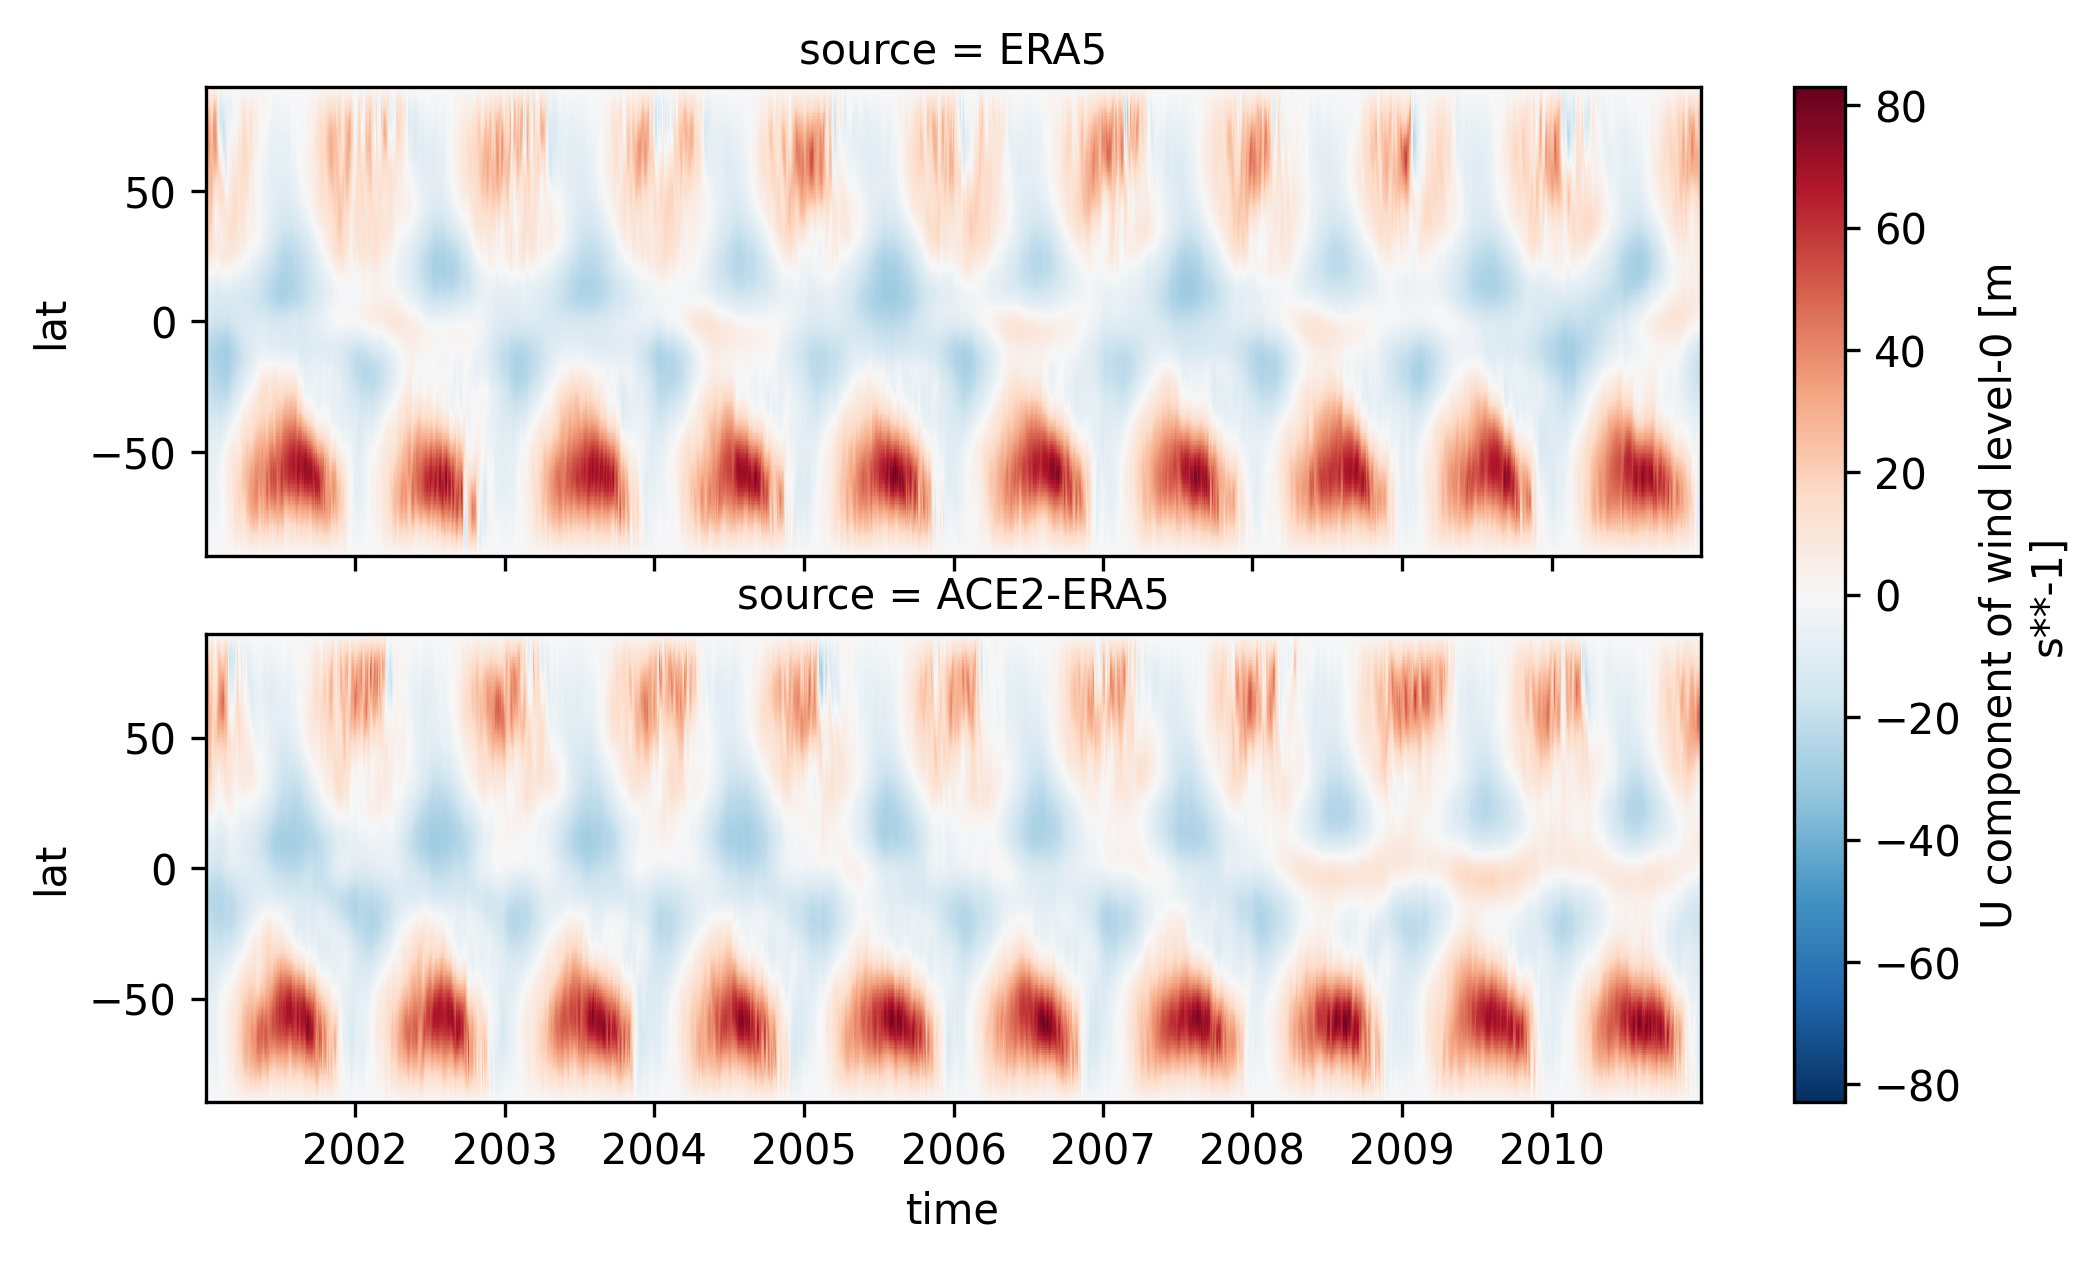

In [6]:
fg = ds_zm.eastward_wind_0.plot(x='time', row='source')
fg.fig.set_size_inches((8, 4))

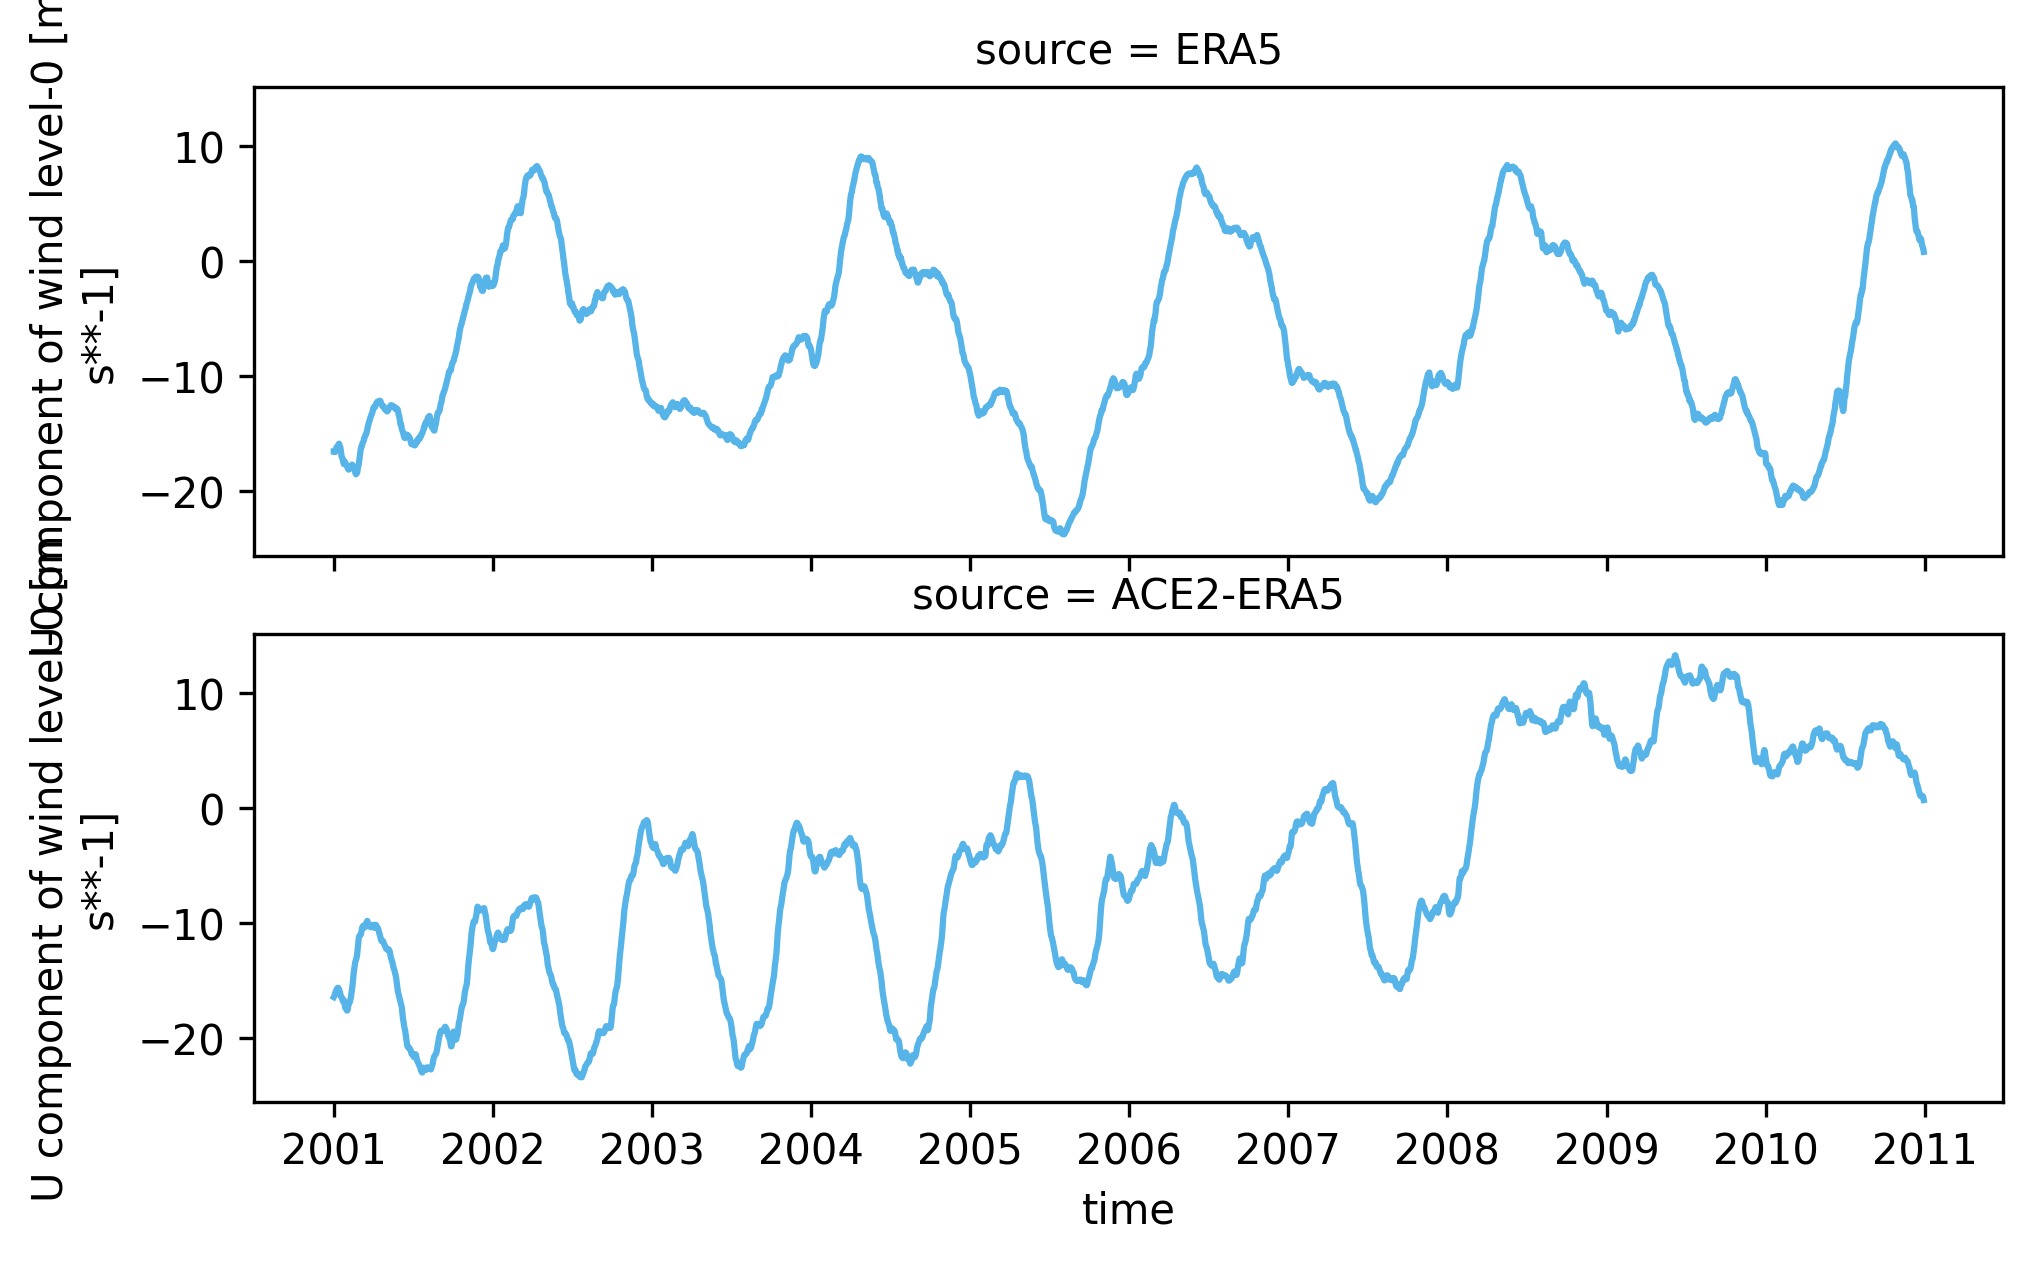

In [7]:
qbo = ds_zm.eastward_wind_0.sel(lat=slice(-5, 5)).mean('lat')
fg = qbo.plot(row='source')
fg.fig.set_size_inches((8, 4))

In [8]:
def compute_and_plot_annual_cycle(ax, da, roll=None, plot_all_years=True, clim_color='k'):
    clim = da.groupby('time.dayofyear').mean('time')
    clim = clim.isel(dayofyear=slice(0, 365))  # drop leap day
    if roll is not None:
        clim = clim.roll(dayofyear=-roll, roll_coords=True)
        increasing_dayofyear = clim.dayofyear.values
        increasing_dayofyear[-roll:] += 365
        clim['dayofyear'] = increasing_dayofyear
        clim['dayofyear'].attrs['long_name'] = f'Day of year (shifted by {roll})'
    start_year = da.time.dt.year.min().values.item()
    end_year = da.time.dt.year.max().values.item()
    by_day_of_year = []
    for year in range(start_year, end_year + 1):
        current_year = da.sel(time=str(year)).groupby('time.dayofyear').mean('time')
        current_year = current_year.isel(dayofyear=slice(0, 365))  # drop leap day
        if roll is not None:
            current_year = current_year.roll(dayofyear=-roll, roll_coords=True)
            increasing_dayofyear = current_year.dayofyear.values
            increasing_dayofyear[-roll:] += 365
            current_year['dayofyear'] = increasing_dayofyear
            current_year['dayofyear'].attrs['long_name'] = f'Day of year (shifted by {roll})'
        current_year = current_year.assign_coords(year=year)
        by_day_of_year.append(current_year)
    by_day_of_year = xr.concat(by_day_of_year, dim='year')
    if plot_all_years:
        for year in range(start_year, end_year + 1):
            by_day_of_year.sel(year=year).plot(ax=ax, color='gray', alpha=0.5, linewidth=0.8)
    else:
        percentiles = [0.05, 0.95]
        wind_quantiles = by_day_of_year.quantile(percentiles, dim='year')
        for p in percentiles:
            if p == percentiles[0]:
                label = f'5th-95th percentile {da.source.values.item()}'
            else:
                label = None
            wind_quantiles.sel(quantile=p).plot(ax=ax, color=clim_color, linewidth=0.8, linestyle='--', label=label)
    clim.plot(ax=ax, color=clim_color, linestyle='-', label=f'Climatology')
    ax.legend(prop={'size': 8})

In [9]:
def plot_combined_annual_cycle(da, lat, axes, roll=None, ylim=None, two_panel=True, ylabel=None):
    if roll == 180:
        ticks = [datetime.datetime(2001, month, 1) for month in [7, 10, 1, 4]] + [datetime.datetime(2001, 6, 30)]
        tick_labels = [t.strftime('%b %-d') for t in ticks]
        tick_day_of_year = [t.timetuple().tm_yday for t in ticks]
        tick_day_of_year[2] += 365
        tick_day_of_year[3] += 365
        tick_day_of_year[4] += 365
    else:
        ticks = [datetime.datetime(2001, month, 1) for month in [1, 4, 7, 10]] + [datetime.datetime(2001, 12, 31)]
        tick_labels = [t.strftime('%b %-d') for t in ticks]
        tick_day_of_year = [t.timetuple().tm_yday for t in ticks]

    if two_panel:
        for i, source in enumerate(['ERA5', 'ACE2-ERA5']):
            da = ds_zm.eastward_wind_0.sel(source=source).sel(lat=lat, method='nearest')
            compute_and_plot_annual_cycle(axes[i], da, roll=roll)
            axes[i].set_title(source)  
        
    else:
        colors = ['r', 'b']
        for i, source in enumerate(['ERA5', 'ACE2-ERA5']):
            da = ds_zm.eastward_wind_0.sel(source=source).sel(lat=lat, method='nearest')
            compute_and_plot_annual_cycle(axes[0], da, roll=roll, plot_all_years=False, clim_color=colors[i])
        
    for ax in axes:
        if ylim is not None:
            ax.set_ylim(ylim)
        if ylabel is not None:
            ax.set_ylabel(ylabel)
        ax.hlines(0, 0, 1, transform=ax.get_yaxis_transform(), color='k', linestyle='--', linewidth=0.5)
        ax.set_xticks(tick_day_of_year)
        ax.set_xticklabels(tick_labels)
        ax.set_xlabel('')


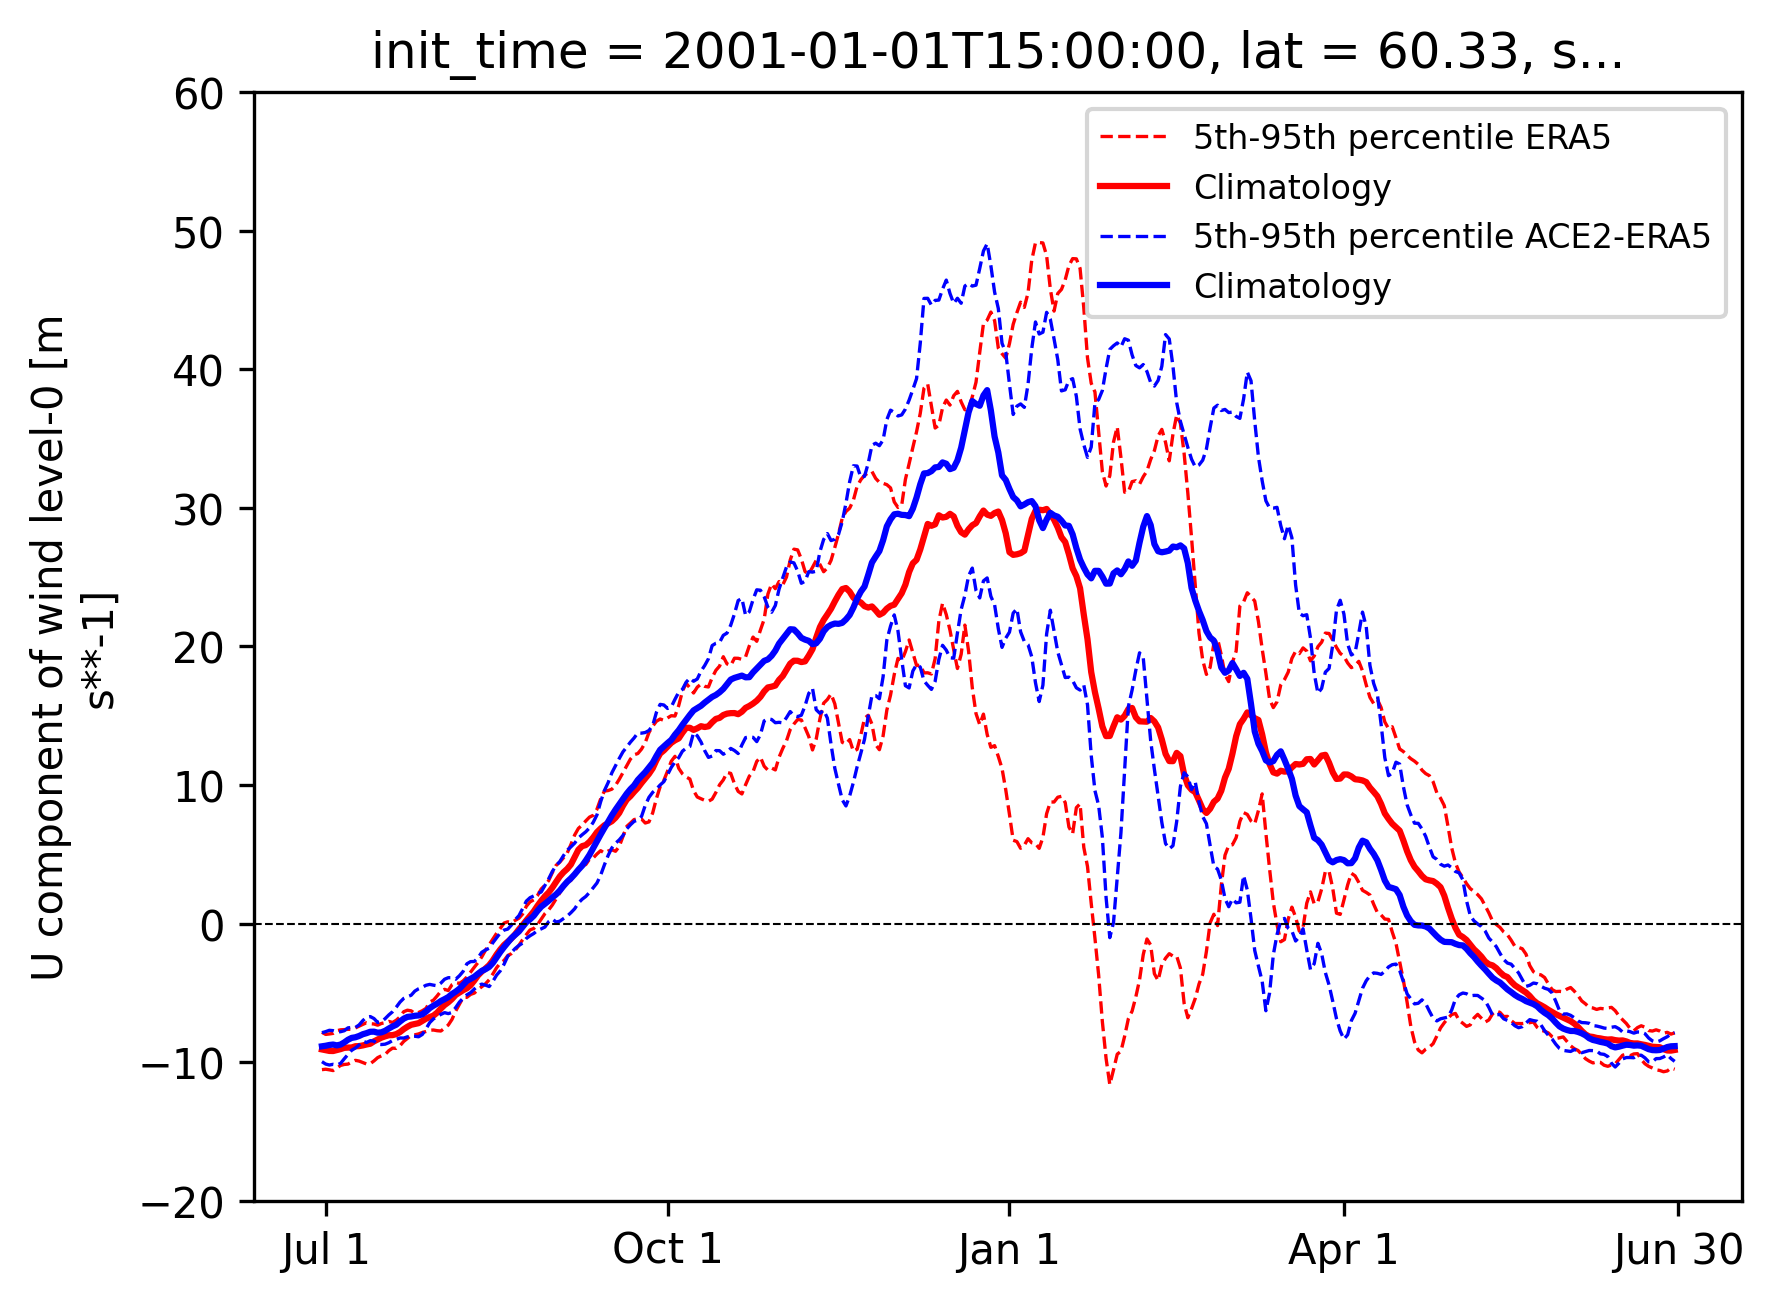

In [10]:
fig, axes = plt.subplots(1, 1)
plot_combined_annual_cycle(ds_zm.eastward_wind_0, 60, fig.axes, roll=180, ylim=[-20, 60], two_panel=False)

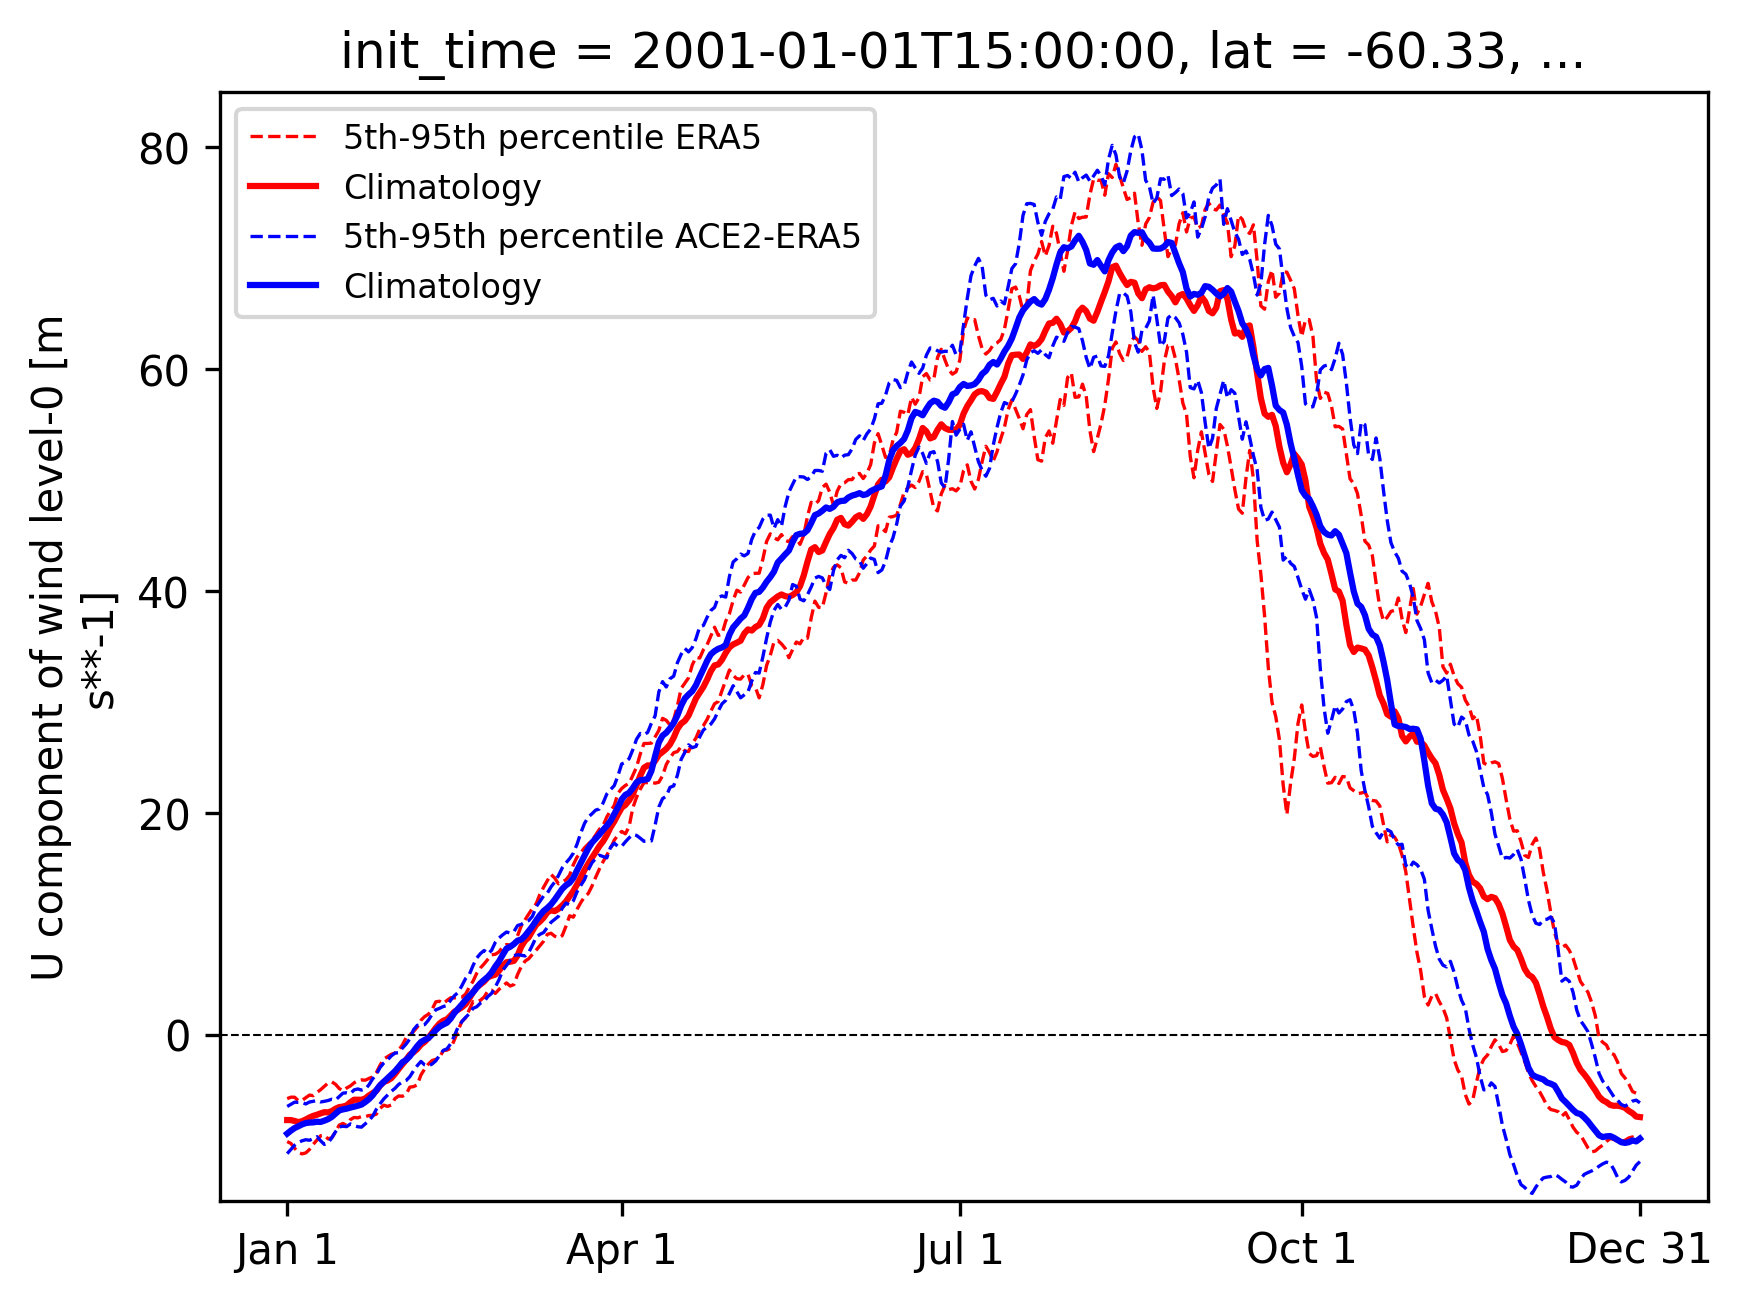

In [11]:
fig, axes = plt.subplots(1, 1)
plot_combined_annual_cycle(ds_zm.eastward_wind_0, -60, fig.axes, ylim=[-15, 85], two_panel=False)

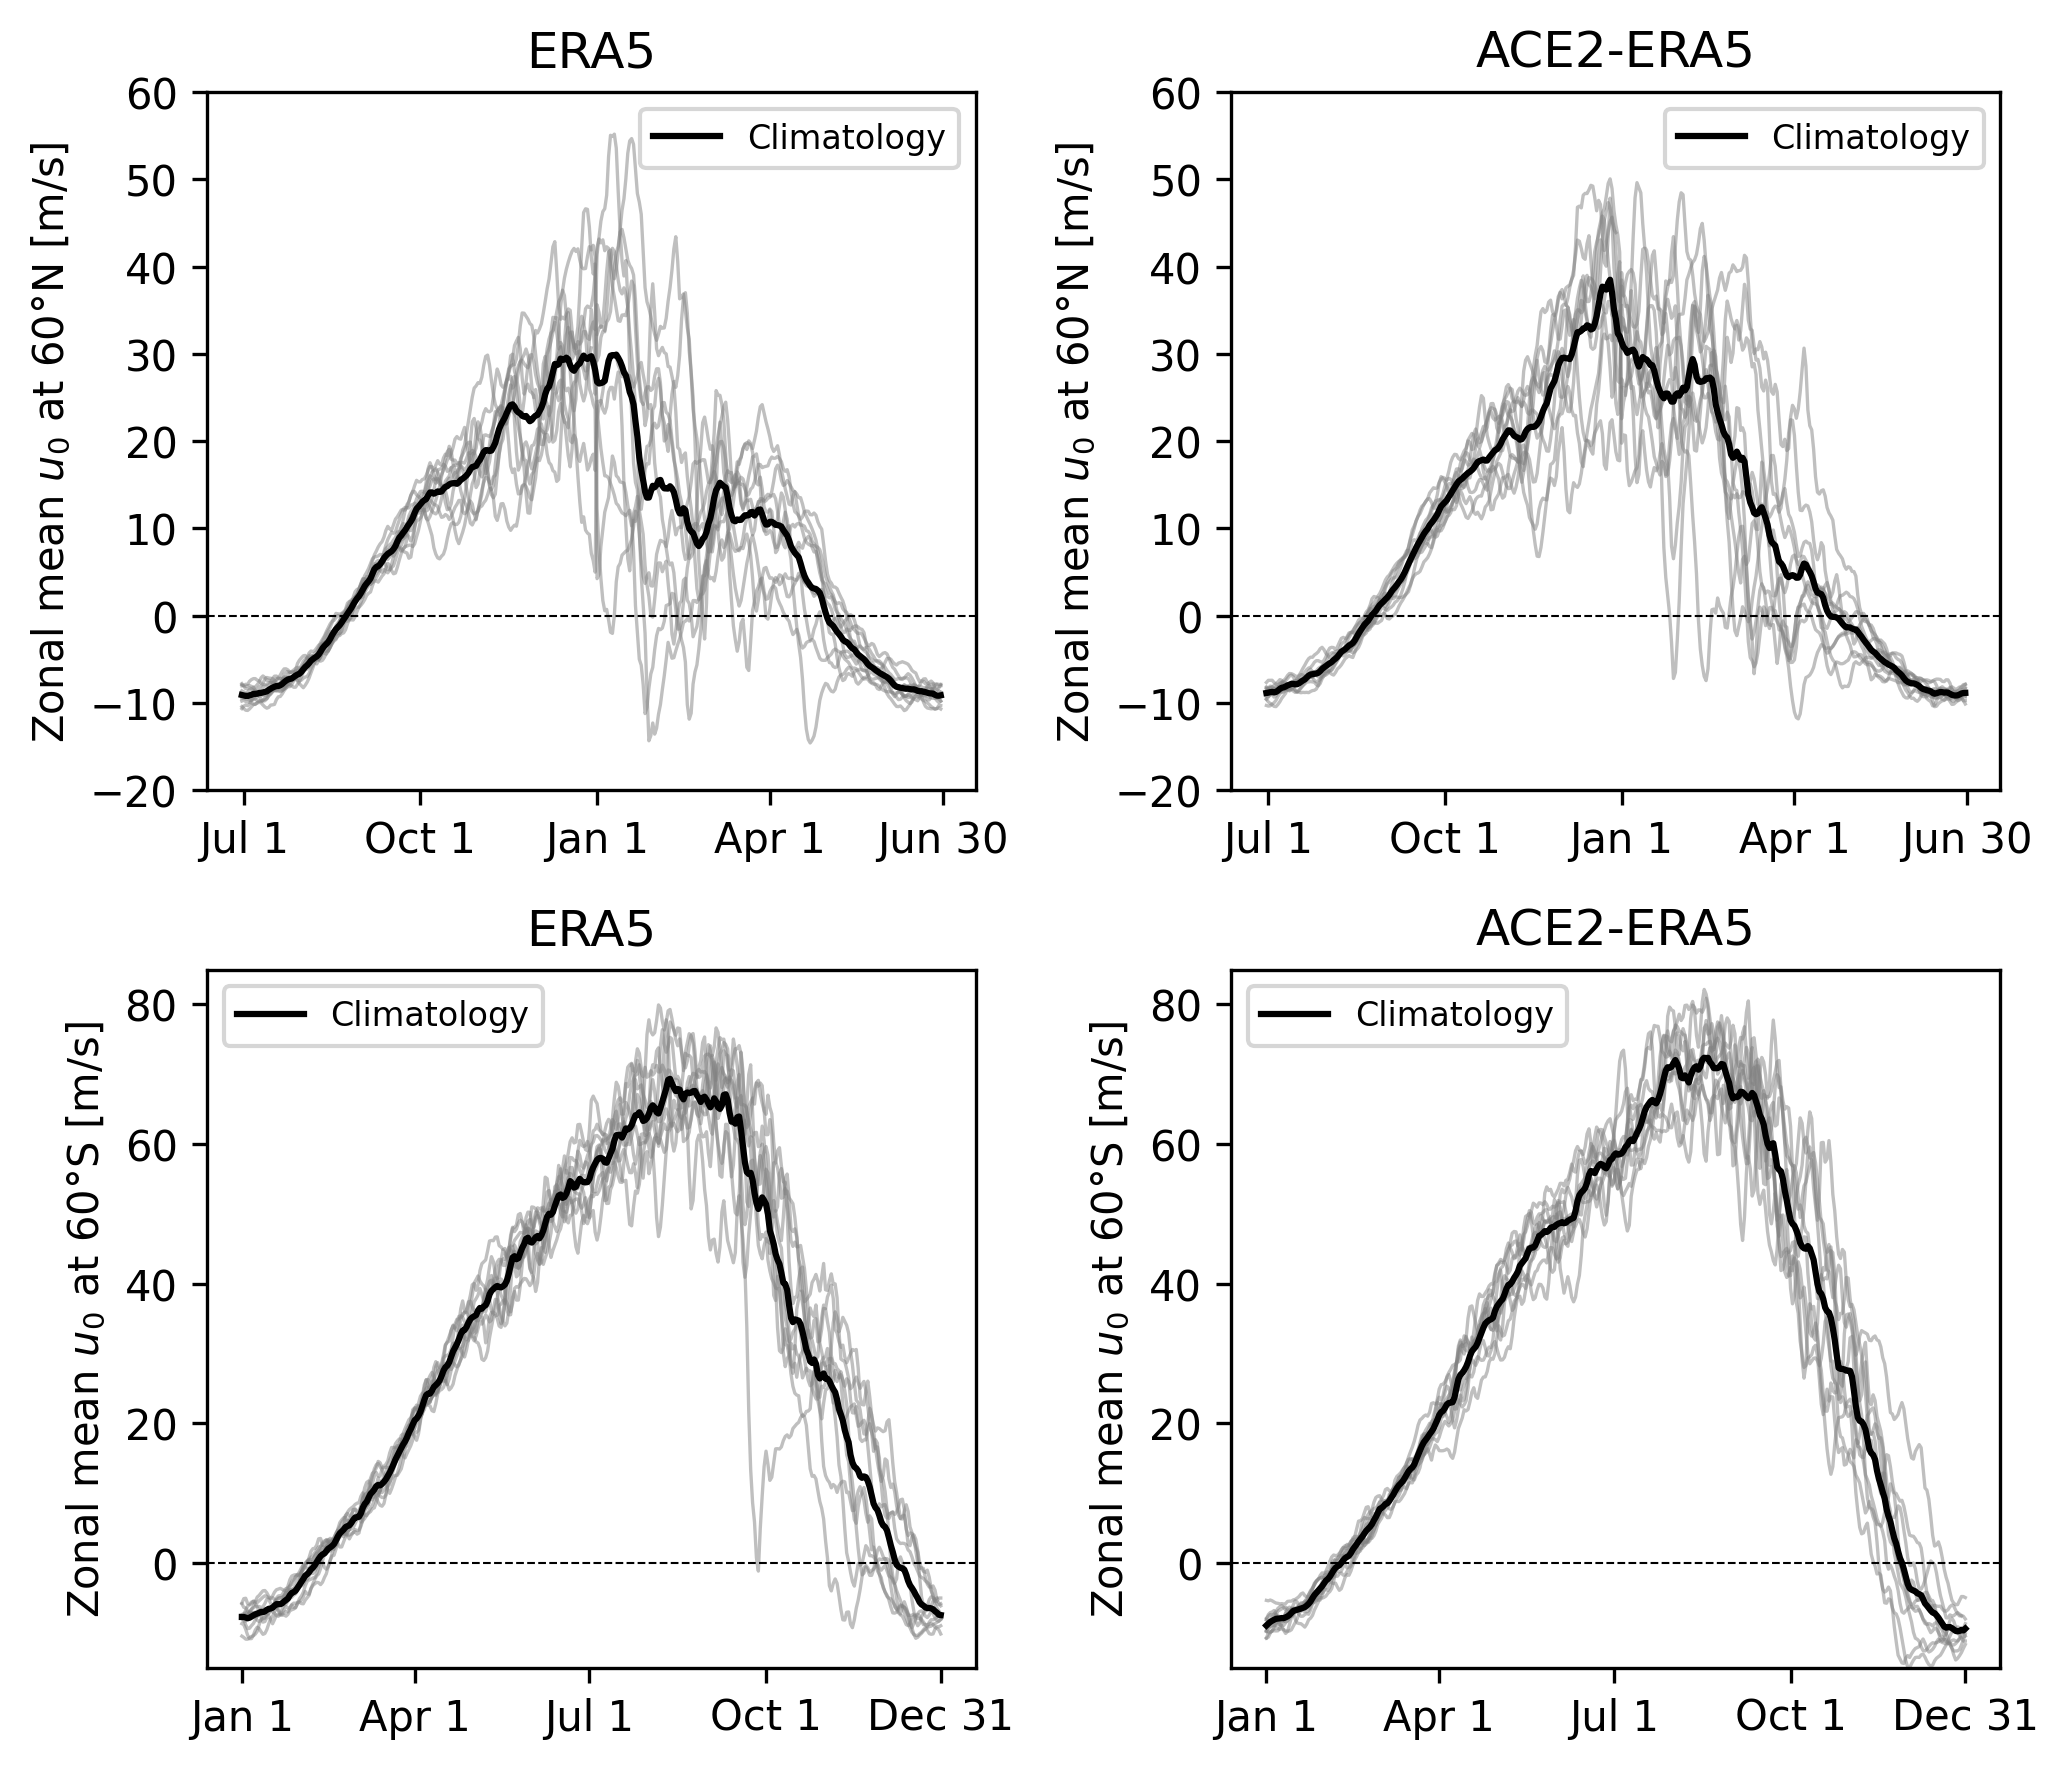

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(7, 6))
ylabel = 'Zonal mean $u_0$ at 60°N [m/s]'
plot_combined_annual_cycle(ds_zm.eastward_wind_0, 60, axes[0], roll=180, ylim=[-20, 60], ylabel=ylabel)
ylabel = 'Zonal mean $u_0$ at 60°S [m/s]'
plot_combined_annual_cycle(ds_zm.eastward_wind_0, -60, axes[1], ylim=[-15, 85], ylabel=ylabel)
fig.tight_layout()
fig.savefig('figures/era5_annual_cycle_u0_60N_60S.png', dpi=300)